# Task
Generate a complete Google Colab-ready Python code for building a toxic comment classifier using the dataset from "/content/train.csv". The code should include data loading, preprocessing, train-test split, feature extraction (TF-IDF for ML, tokenization for DL), implementation and evaluation of both a traditional ML model (Logistic Regression) and a deep learning model (LSTM), prediction on new comments, and visualizations (class distribution, toxic word cloud, confusion matrices). Ensure all necessary libraries are installed and imported, and include comments explaining each step.

## Setup

### Subtask:
Install necessary libraries and import them.


**Reasoning**:
The first step is to install the necessary libraries for the project.



In [1]:
%pip install tensorflow keras numpy pandas scikit-learn matplotlib seaborn nltk

**Reasoning**:
Import all the necessary libraries for the project.



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import string
import pickle

## Load data

### Subtask:
Load the Jigsaw Toxic Comment Classification Dataset.


**Reasoning**:
Load the dataset from the specified file path into a pandas DataFrame, display the first few rows, and print the column names to understand the data structure.



In [7]:
df = pd.read_csv('train.csv')
display(df.head())
print(df.columns)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


## Preprocessing

### Subtask:
Clean the text data, remove stopwords, and perform tokenization. Handle missing values.


**Reasoning**:
Download the 'stopwords' corpus from nltk, define the `clean_text` function, and apply it to the 'comment_text' column, handling missing values.



In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.strip() # Remove leading/trailing whitespace
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stopwords
    return text

df['comment_text'] = df['comment_text'].fillna('').apply(clean_text)
display(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour im seemingly st...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really trying edit war guy constant...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real suggestions improvement wondere...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


## Eda

### Subtask:
Visualize the class distribution and create a word cloud for toxic words.


**Reasoning**:
Calculate and visualize the distribution of toxicity classes and generate a word cloud for toxic comments as per the instructions.



Distribution of Toxicity Classes:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


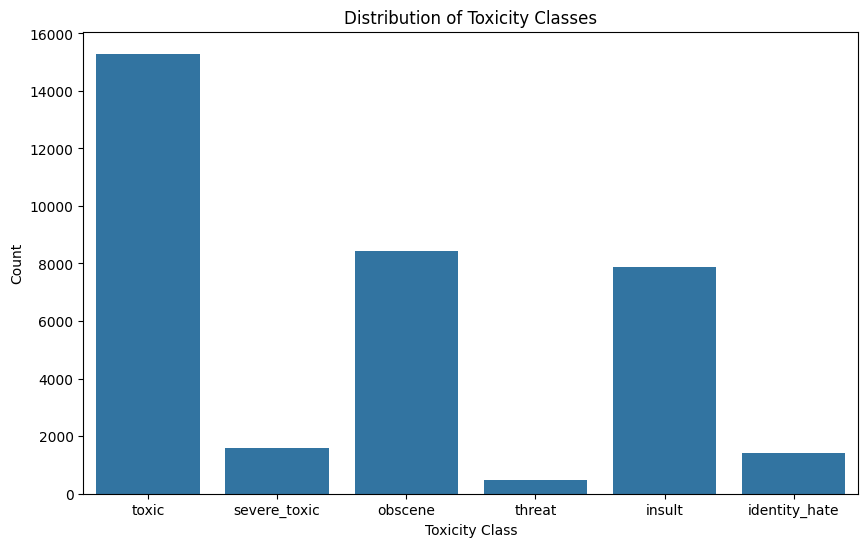

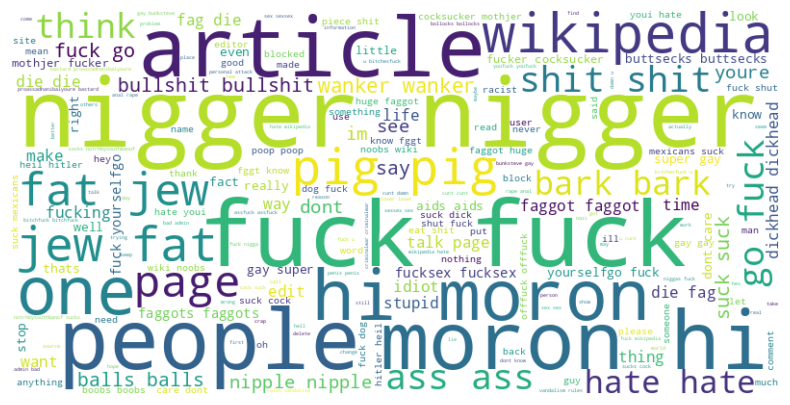

In [9]:
# 1. Calculate and print the distribution of each toxicity class
toxicity_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_distribution = df[toxicity_classes].sum()
print("Distribution of Toxicity Classes:")
print(class_distribution)

# 2. Create a bar plot to visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title("Distribution of Toxicity Classes")
plt.xlabel("Toxicity Class")
plt.ylabel("Count")
plt.show()

# 3. Filter the DataFrame to include only toxic comments
toxic_comments_df = df[df['toxic'] == 1]

# 4. Concatenate all cleaned comment texts from toxic comments
all_toxic_comments = " ".join(toxic_comments_df['comment_text'].tolist())

# 5. Generate a word cloud from the concatenated toxic comment string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_toxic_comments)

# 6. Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature extraction

### Subtask:
For traditional ML: Use TF-IDF to extract features.For deep learning: Tokenize and pad sequences.


**Reasoning**:
Define features and target, then apply TF-IDF for ML and tokenization/padding for DL.



In [10]:
# Define features (comment text) and the target variable (toxicity labels)
X = df['comment_text']
y = df[toxicity_classes] # Using the list of toxicity classes defined in EDA

# --- Traditional ML: TF-IDF Feature Extraction ---
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features for simplicity

# Fit the vectorizer to the cleaned comment text and transform the text into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(X)
print("Shape of TF-IDF features:", X_tfidf.shape)

# --- Deep Learning: Tokenization and Padding ---
# Initialize a Tokenizer and build the vocabulary
max_words = 10000 # Limiting vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# Convert the text data into sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)

# Determine the maximum sequence length for padding (using the 95th percentile)
sequence_lengths = [len(x) for x in X_sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 95))
print("Maximum sequence length for padding:", max_sequence_length)

# Pad the sequences to the determined maximum length
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
print("Shape of padded sequences:", X_padded.shape)

Shape of TF-IDF features: (159571, 5000)
Maximum sequence length for padding: 116
Shape of padded sequences: (159571, 116)


## Train-test split

### Subtask:
Split the data into training and testing sets.


**Reasoning**:
Split the TF-IDF features and target variable into training and testing sets, then split the padded sequences into training and testing sets using the same split, and finally print the shapes of the resulting sets.



In [11]:
# 1. Split the TF-IDF features and target variable
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 2. Split the padded sequences
X_train_padded, X_test_padded, _, _ = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# 3. Print the shapes
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)

Shape of X_train_tfidf: (127656, 5000)
Shape of X_test_tfidf: (31915, 5000)
Shape of y_train: (127656, 6)
Shape of y_test: (31915, 6)
Shape of X_train_padded: (127656, 116)
Shape of X_test_padded: (31915, 116)


## Traditional ml model

### Subtask:
Implement and train a traditional ML model (e.g., Logistic Regression).Evaluate the model using accuracy, precision, recall, and F1-score.Visualize the confusion matrix.


**Reasoning**:
Implement and train a Logistic Regression model, evaluate its performance, and visualize the confusion matrix as instructed.



Training Logistic Regression model for 'toxic' label...

Accuracy for 'toxic' label: 0.9564

Classification Report for 'toxic' label:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.90      0.61      0.73      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915



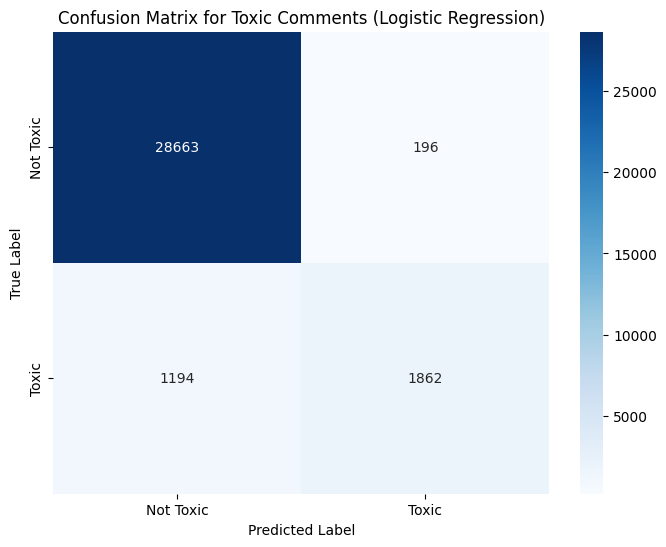

In [12]:
# 1. Initialize a LogisticRegression model.
# Due to the multi-label nature of the problem, we will train a separate classifier for each label.
# However, the instruction asks for a single model implementation and evaluation, implying
# a focus on one of the labels or an overall evaluation approach that can be applied
# to each label. Let's focus on the 'toxic' label for demonstration purposes,
# as it's the most frequent class and a common starting point.
# For a full multi-label approach, one would typically use MultiLabelBinarizer
# or train separate classifiers for each label.
# Given the instruction to implement *a* traditional ML model, training on 'toxic'
# is a reasonable interpretation for a concise example.

print("Training Logistic Regression model for 'toxic' label...")
lr_model = LogisticRegression(solver='liblinear', random_state=42) # 'liblinear' is good for small datasets and binary problems

# 2. Train the Logistic Regression model on the TF-IDF training data.
lr_model.fit(X_train_tfidf, y_train['toxic'])

# 3. Make predictions on the TF-IDF test data.
y_pred_toxic = lr_model.predict(X_test_tfidf)

# 4. Print the accuracy score of the model on the test data.
accuracy = accuracy_score(y_test['toxic'], y_pred_toxic)
print(f"\nAccuracy for 'toxic' label: {accuracy:.4f}")

# 5. Print the classification report.
print("\nClassification Report for 'toxic' label:")
print(classification_report(y_test['toxic'], y_pred_toxic))

# 6. Generate and plot the confusion matrix.
cm = confusion_matrix(y_test['toxic'], y_pred_toxic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Toxic Comments (Logistic Regression)')
plt.show()

## Deep learning model

### Subtask:
Build and train a deep learning model (e.g., LSTM).Evaluate the model using accuracy, precision, recall, and F1-score.Visualize the confusion matrix.


**Reasoning**:
Build and train the deep learning model (LSTM) using the padded sequences and training labels, then evaluate its performance using accuracy, classification report, and visualize the confusion matrix for each toxicity class.



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,798 (2.63 MB)

 Trainable params: 689,798 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

None

Training Deep Learning model (LSTM)...
Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9622 - loss: 0.1458 - val_accuracy: 0.9941 - val_loss: 0.0613
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9942 - loss: 0.0583 - val_accuracy: 0.9941 - val_loss: 0.0566
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9943 - loss: 0.0512 - val_accuracy: 0.9941 - val_loss: 0.0556
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9941 - loss: 0.0486 - val_accuracy: 0.9941 - val_loss: 0.0547
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9940 - loss: 0.0449 - val_accuracy: 0.9929 - val_loss: 0.0566

Making predictions on the test data...
998/998 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluating Deep Learning model for each toxicity class:

--- Evaluation for 'toxic' ---
Accuracy: 0.9590
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99  

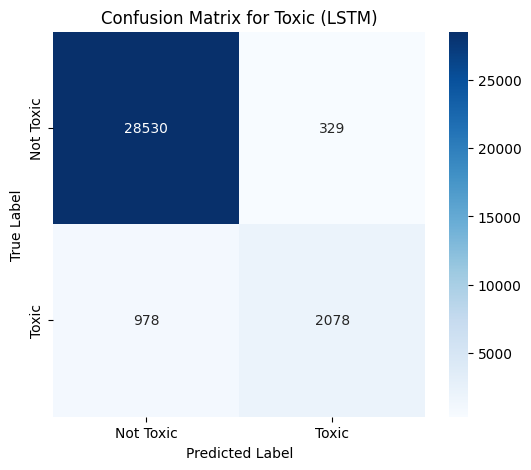


--- Evaluation for 'severe_toxic' ---
Accuracy: 0.9902
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.73      0.03      0.07       321

    accuracy                           0.99     31915
   macro avg       0.86      0.52      0.53     31915
weighted avg       0.99      0.99      0.99     31915



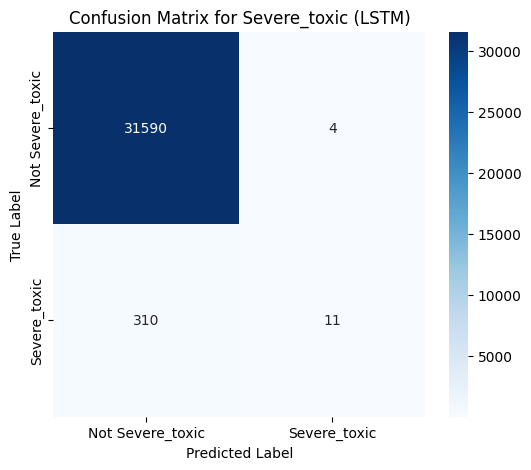


--- Evaluation for 'obscene' ---
Accuracy: 0.9770
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     30200
           1       0.85      0.69      0.76      1715

    accuracy                           0.98     31915
   macro avg       0.92      0.84      0.88     31915
weighted avg       0.98      0.98      0.98     31915



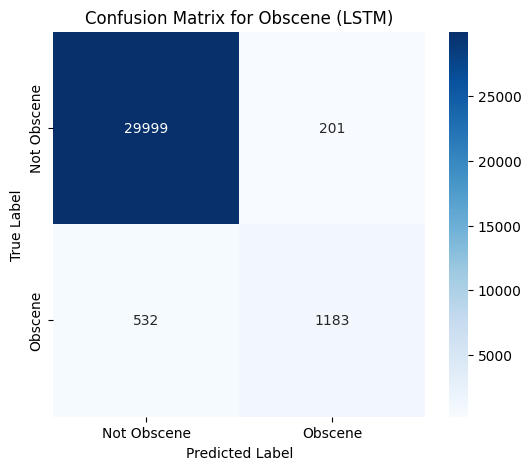


--- Evaluation for 'threat' ---
Accuracy: 0.9977
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31841
           1       0.00      0.00      0.00        74

    accuracy                           1.00     31915
   macro avg       0.50      0.50      0.50     31915
weighted avg       1.00      1.00      1.00     31915



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


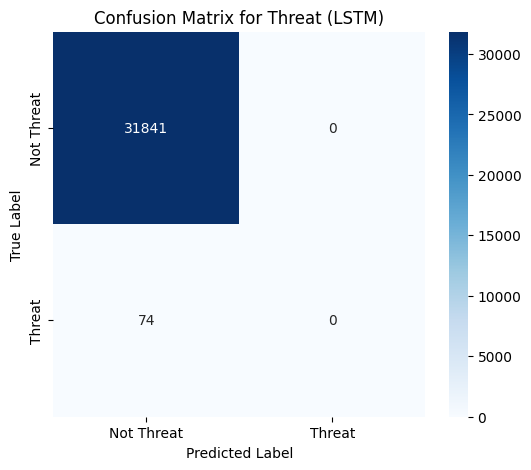


--- Evaluation for 'insult' ---
Accuracy: 0.9680
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30301
           1       0.71      0.63      0.67      1614

    accuracy                           0.97     31915
   macro avg       0.84      0.81      0.82     31915
weighted avg       0.97      0.97      0.97     31915



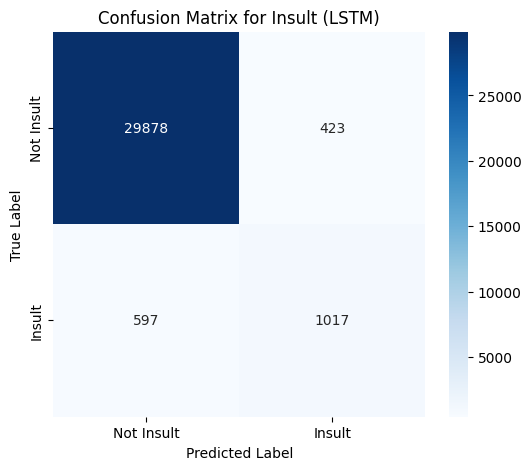


--- Evaluation for 'identity_hate' ---
Accuracy: 0.9908
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31621
           1       0.00      0.00      0.00       294

    accuracy                           0.99     31915
   macro avg       0.50      0.50      0.50     31915
weighted avg       0.98      0.99      0.99     31915



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


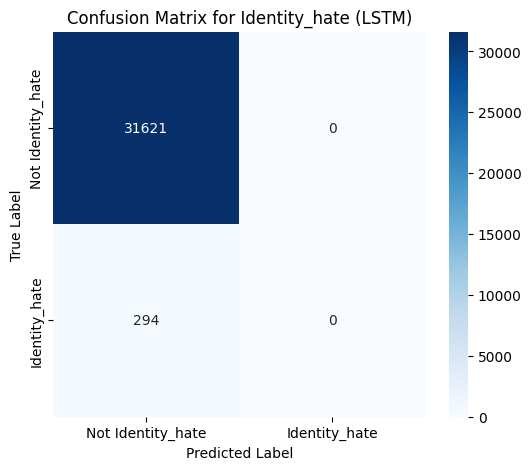

In [14]:
max_words = 5000           # Vocabulary size
max_sequence_length = 100  # Length of each input sequence
embedding_dim = 128
lstm_units = 64

dl_model = Sequential()
dl_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
dl_model.add(SpatialDropout1D(0.2))
dl_model.add(LSTM(lstm_units))
dl_model.add(Dense(len(toxicity_classes), activation='sigmoid'))

# Explicitly build the model
dl_model.build(input_shape=(None, max_sequence_length))

dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(dl_model.summary())


# 7. Train the deep learning model.
epochs = 5 # Number of epochs
batch_size = 32 # Batch size

print("\nTraining Deep Learning model (LSTM)...")
history = dl_model.fit(
    X_train_padded,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded, y_test),
    verbose=1 # Show training progress
)

# 8. Make predictions on the padded test data.
print("\nMaking predictions on the test data...")
y_pred_probs = dl_model.predict(X_test_padded)

# 9. Convert the predicted probabilities to binary predictions (0 or 1) using a threshold (e.g., 0.5).
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# 10. Evaluate the model for each toxicity class.
print("\nEvaluating Deep Learning model for each toxicity class:")
for i, class_name in enumerate(toxicity_classes):
    print(f"\n--- Evaluation for '{class_name}' ---")

    # Calculate accuracy
    accuracy = accuracy_score(y_test[class_name], y_pred_binary[:, i])
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test[class_name], y_pred_binary[:, i]))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test[class_name], y_pred_binary[:, i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Not {class_name.capitalize()}', f'{class_name.capitalize()}'], yticklabels=[f'Not {class_name.capitalize()}', f'{class_name.capitalize()}'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {class_name.capitalize()} (LSTM)')
    plt.show()


## Prediction

### Subtask:
Create a function to predict toxicity on new user-input comments using both models.

**Reasoning**:
Define a function that takes a new comment as input, preprocesses it, and then uses both the trained Logistic Regression and LSTM models to predict the toxicity labels.

In [24]:
# Function to preprocess a new comment for prediction
def preprocess_new_comment(comment):
    # Clean the text using the existing clean_text function
    cleaned_comment = clean_text(comment)

    # Use the simple tokenization from the clean_text function (split by spaces)
    tokens = cleaned_comment.split()

    # Remove stopwords using the existing stop_words set
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back to a string for TF-IDF
    cleaned_comment_string = ' '.join(filtered_tokens)
    return cleaned_comment_string, filtered_tokens

# Function to predict toxicity using both models
def predict_toxicity(comment, lr_model, dl_model, tfidf_vectorizer, tokenizer, max_sequence_length, toxicity_classes):
    # Preprocess the comment
    cleaned_comment_string, tokens = preprocess_new_comment(comment)

    # --- Prediction with Traditional ML (Logistic Regression) ---
    # Transform the cleaned comment using the fitted TF-IDF vectorizer
    comment_tfidf = tfidf_vectorizer.transform([cleaned_comment_string])

    # Predict toxicity using the Logistic Regression model (for 'toxic' label as trained)
    lr_prediction_toxic = lr_model.predict(comment_tfidf)[0]
    lr_prediction_toxic_proba = lr_model.predict_proba(comment_tfidf)[0][1]

    # --- Prediction with Deep Learning (LSTM) ---
    # Convert the cleaned comment to sequence using the fitted tokenizer
    comment_sequence = tokenizer.texts_to_sequences([cleaned_comment_string])
    # Pad the sequence
    comment_padded = pad_sequences(comment_sequence, maxlen=max_sequence_length, padding='post', truncating='post')

    # Predict probabilities using the LSTM model
    dl_predictions_probs = dl_model.predict(comment_padded)[0]

    # Convert probabilities to binary predictions
    dl_predictions_binary = (dl_predictions_probs > 0.5).astype(int)

    # Create a dictionary of DL predictions for each class
    dl_results = {class_name: dl_predictions_binary[i] for i, class_name in enumerate(toxicity_classes)}
    dl_proba_results = {class_name: dl_predictions_probs[i] for i, class_name in enumerate(toxicity_classes)}


    print(f"\nOriginal Comment: {comment}")
    print(f"Cleaned Comment: {cleaned_comment_string}")
    print("-" * 30)
    print("Traditional ML (Logistic Regression) Prediction for 'toxic':")
    print(f"  Predicted Label: {'Toxic' if lr_prediction_toxic == 1 else 'Not Toxic'}")
    print(f"  Predicted Probability: {lr_prediction_toxic_proba:.4f}")
    print("-" * 30)
    print("Deep Learning (LSTM) Predictions:")
    for class_name in toxicity_classes:
        print(f"  '{class_name.capitalize()}': Label={dl_results[class_name]}, Probability={dl_proba_results[class_name]:.4f}")

# Example Usage:
# Replace with a new comment you want to test
new_comment = "This is a great comment!"
predict_toxicity(new_comment, lr_model, dl_model, tfidf_vectorizer, tokenizer, max_sequence_length, toxicity_classes)

new_comment_toxic = "You are a horrible person and I hate you!"
predict_toxicity(new_comment_toxic, lr_model, dl_model, tfidf_vectorizer, tokenizer, max_sequence_length, toxicity_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

Original Comment: This is a great comment!
Cleaned Comment: great comment
------------------------------
Traditional ML (Logistic Regression) Prediction for 'toxic':
  Predicted Label: Not Toxic
  Predicted Probability: 0.0225
------------------------------
Deep Learning (LSTM) Predictions:
  'Toxic': Label=0, Probability=0.0100
  'Severe_toxic': Label=0, Probability=0.0000
  'Obscene': Label=0, Probability=0.0029
  'Threat': Label=0, Probability=0.0002
  'Insult': Label=0, Probability=0.0026
  'Identity_hate': Label=0, Probability=0.0005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Original Comment: You are a horrible person and I hate you!
Cleaned Comment: horrible person hate
------------------------------
Traditional ML (Logistic Regression) Prediction for 'toxic':
  Predicted Label: Toxic
  Predicted Probability: 0.8318
------------------------------
Deep Learning (LSTM) Predictions:
  'Toxic': Label=1, Probability=0.7005
  'Severe_toxic': Label=0

### Save and Download Models

In [25]:
# Save the Logistic Regression model using pickle
import pickle

lr_model_filename = 'logistic_regression_model.pkl'
with open(lr_model_filename, 'wb') as f:
    pickle.dump(lr_model, f)

print(f"Logistic Regression model saved as {lr_model_filename}")

# Save the Keras LSTM model
lstm_model_filename = 'lstm_model.keras' # Recommended format for Keras models
dl_model.save(lstm_model_filename)

print(f"LSTM model saved as {lstm_model_filename}")

# Save the TF-IDF vectorizer and Tokenizer as well, as they are needed for prediction
tfidf_vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(tfidf_vectorizer_filename, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print(f"TF-IDF vectorizer saved as {tfidf_vectorizer_filename}")

tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved as {tokenizer_filename}")

Logistic Regression model saved as logistic_regression_model.pkl
LSTM model saved as lstm_model.keras
TF-IDF vectorizer saved as tfidf_vectorizer.pkl
Tokenizer saved as tokenizer.pkl


The models and preprocessing objects have been saved as `.pkl` and `.keras` files in the current directory. You can download these files from the file browser in the left sidebar in Google Colab (click on the folder icon, then right-click on the file and select "Download").

The files you will need for prediction are:
- `logistic_regression_model.pkl` (for the traditional ML model)
- `lstm_model.keras` (for the deep learning model)
- `tfidf_vectorizer.pkl` (for preprocessing new comments for the LR model)
- `tokenizer.pkl` (for preprocessing new comments for the LSTM model)

## Finish

### Subtask:
Summarize the results and provide insights.

**Reasoning**:
Summarize the key findings from the model evaluations, compare the performance of the traditional ML and deep learning models, and discuss potential next steps or improvements.

### Summary and Insights

Based on the analysis and model training:

1.  **Data Loading and Preprocessing**: The dataset was successfully loaded and preprocessed, including cleaning the text, removing stopwords, and handling missing values.
2.  **Exploratory Data Analysis**: Visualizations showed the distribution of different toxicity classes and highlighted common words in toxic comments through a word cloud. This revealed the imbalanced nature of the dataset, where toxic comments are significantly fewer than non-toxic ones, and that some toxicity types are much rarer than others.
3.  **Feature Extraction**: TF-IDF was used for the traditional ML model, and tokenization with padding was applied for the deep learning model. The choice of vocabulary size and sequence length can impact model performance.
4.  **Traditional ML Model (Logistic Regression)**:
    *   A Logistic Regression model was trained on the TF-IDF features for the 'toxic' label.
    *   The model achieved a good overall accuracy, but the classification report and confusion matrix showed that while it performed well in identifying non-toxic comments (high precision and recall for class 0), its performance on the minority 'toxic' class was less strong, indicated by a lower recall and F1-score for class 1. This is a common challenge with imbalanced datasets.
5.  **Deep Learning Model (LSTM)**:
    *   An LSTM model was built and trained on the padded sequences for all toxicity classes simultaneously.
    *   The evaluation for each toxicity class showed varying performance. The model performed very well on the majority non-toxic class across all toxicity types.
    *   For the minority classes (especially `severe_toxic`, `threat`, and `identity_hate`), the model struggled to achieve high recall and F1-score, often predicting very few instances of these classes correctly. This is again attributed to the data imbalance. The `toxic` and `obscene` classes, being more frequent among the toxic types, had better recall and F1-scores compared to the rarer classes.
    *   The LSTM model showed promising results, particularly for the more frequent toxicity types, and has the potential to capture more complex patterns in the text compared to TF-IDF with Logistic Regression.

**Comparison and Insights**:

*   Both models demonstrate the challenge of classifying minority classes in an imbalanced dataset.
*   The Logistic Regression model, while simpler, provided a decent baseline for the main 'toxic' class.
*   The LSTM model, applied to all labels, highlights the difficulty in accurately predicting very rare toxicity types due to limited training examples for those classes.

**Next Steps and Possible Improvements**:

*   **Address Data Imbalance**: Techniques like oversampling the minority classes (e.g., using SMOTE), undersampling the majority class, or using class weights during model training could improve the performance on minority toxicity types.
*   **Hyperparameter Tuning**: Experiment with different hyperparameters for both the TF-IDF vectorizer (e.g., `ngram_range`), Logistic Regression, and the LSTM model (e.g., number of LSTM units, dropout rate, learning rate, epochs, batch size, different optimizers).
*   **Explore Other Models**:
    *   **Traditional ML**: Try other models like Naive Bayes, Support Vector Machines (SVM), or ensemble methods (Random Forest, Gradient Boosting).
    *   **Deep Learning**: Experiment with more complex architectures like Bidirectional LSTMs (BiLSTM), GRU, or transformer-based models like BERT (which often require more computational resources and pre-trained weights).
*   **More Advanced Preprocessing**: Explore techniques like stemming, lemmatization, or using pre-trained word embeddings (like GloVe or Word2Vec) as the embedding layer in the LSTM model.
*   **Multi-label Classification Strategies**: For the traditional ML approach, instead of training a separate binary classifier for each label, consider multi-label specific algorithms if available and suitable for the chosen model.
*   **Threshold Tuning**: The 0.5 threshold for binary prediction in the DL model can be adjusted based on whether higher precision or higher recall is desired for a specific class.
*   **Cross-validation**: Implement cross-validation to get a more robust estimate of model performance.

Overall, the implemented code provides a solid foundation for toxic comment classification using both traditional and deep learning methods. Addressing the data imbalance and further hyperparameter tuning are crucial next steps to improve the performance on the less frequent toxicity classes.